# Komparasi Spike Gene dari NCOV-2019 (NCBI Database)
* Pada notebook ini dilakukan komparasi sekuen untuk melihat motif (konservasi sekuen) dari sampel *spike gene* NCOV-2019 yang berasal dari berbagai lokasi. 
* Cara akuisisi data dari [NCBI](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-CoV-2,%20taxid:2697049) dapat dilihat pada notebook [01_fetch_sequence.ipynb](./01_fetch_sequence.ipynb)
* Hasil akuisisi data dapat dilihat pada file [ncov2019_ncbi_spike_simple.csv](./output/ncov2019_ncbi_spike_simple.csv)

In [1]:
# load library
from pandas import DataFrame
import pandas as pd
from Bio import SeqIO
from os import listdir
from Bio import motifs
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# load data
df = pd.read_csv("output/ncov2019_ncbi_spike_simple.csv", index_col=0)
df

,Accession,Geo_Location,s-gene_location,gene_length,protein_id,protein_length
0,NC_045512,China,[21562:25384](+),3822.0,YP_009724390.1,1273.0
1,MT444148,USA,[21549:25371](+),3822.0,QJQ82624.1,1273.0
2,MT444515,USA,[21530:25352](+),3822.0,QJQ82636.1,1273.0
3,MT444516,USA,[21512:25334](+),3822.0,QJQ82648.1,1273.0
4,MT444517,USA,[21523:25345](+),3822.0,QJQ82660.1,1273.0
...,...,...,...,...,...,...
2415,MN988713,USA,[21562:25384](+),3822.0,QHO62877.1,1273.0
2416,MN938384,China,[21530:25352](+),3822.0,QHN73795.1,1273.0
2423,MN975262,China,[21562:25384](+),3822.0,QHN73810.1,1273.0
2430,MN985325,USA,[21562:25384](+),3822.0,QHO60594.1,1273.0


In [3]:
# jumlah sampel per negara
df['Geo_Location'].value_counts()

USA               2032
China               67
India               28
Thailand            23
Taiwan              22
Hong Kong           21
Spain               21
Puerto Rico         12
Czech Republic       7
Japan                5
Kazakhstan           4
South Korea          4
Malaysia             4
Greece               4
Sri Lanka            4
Iran                 3
Brazil               2
Italy                2
Vietnam              2
Serbia               2
Israel               2
Pakistan             2
Colombia             1
Finland              1
Nepal                1
Sweden               1
Germany              1
Peru                 1
France               1
Netherlands          1
Turkey               1
South Africa         1
Australia            1
Name: Geo_Location, dtype: int64

In [4]:
# ambil 10 sampel dari tiap negara
jumlah_sampel = 10

# container
data_prot = []
data_nuc = []
geo = []

# list location variables
var_geo = df['Geo_Location'].unique()

# get samples
for i in var_geo:
    x = df.loc[df['Geo_Location'] == i, "Accession"]
    p = df.loc[df['Geo_Location'] == i, "protein_id"]
    if len(x) > jumlah_sampel :
        index = list(x.index[0:(jumlah_sampel-1)])
        for y in index:
            data_nuc.append(x[y])
            data_prot.append(p[y])
            geo.append(i)
    else:
        for y in x.values:
            data_nuc.append(y)
            geo.append(i)
        for y in p.values:
            data_prot.append(y)

In [5]:
# buat multiple fasta gen spike dari sampel

# create container
gene_records = []

fasta_gene = listdir("output/gene/")
print('Sample with ambiguous nucleotides:')
for n in data_nuc:
    for i in fasta_gene:
        if n in i:
            records = SeqIO.parse("output/gene/"+i, "fasta")
            seq_record = next(records)
            
            # quality control, remove ambiguos nucleotide
            sequence = str(seq_record.seq).upper()
            amb = float(sequence.count("N"))
            if amb > 0 :
                print(seq_record.id + " " +str(amb))
            else:
                gene_records.append(seq_record)
            #print(seq_record.id)
SeqIO.write(gene_records, "output/spike_nucleotide.faa", "fasta")

Sample with ambiguous nucleotides:
MT434758.1 1.0
MT434760.1 1.0
MT419817.1 3.0
MT394864.1 485.0
MT371568.1 9.0
MT371569.1 39.0
MT372482.1 51.0
MT372483.1 198.0
MT292570.1 1.0


121

In [6]:
# buat multiple fasta untuk protein
protein_records = []
fasta_protein = listdir("output/protein/")
for n in data_prot:
    for i in fasta_protein:
        if n in i:
            records = SeqIO.parse("output/protein/"+i, "fasta")
            seq_record = next(records)
            protein_records.append(seq_record)
            #print(seq_record.id)
SeqIO.write(protein_records, "output/spike_protein.faa", "fasta")

130

In [10]:
def draw_bit_matrix(m, start, stop, title):
    pwm = m.counts.normalize(pseudocounts=0.5)
    pssm = pwm.log_odds()
    matrix_draw = [pssm['A'],pssm['C'],pssm['G'],pssm['T']]
    
    # set the size of the figure
    plt.figure(figsize=[20,2])

    # show the array flipped (transposed) and with no colour interpolation smoothing
    plt.imshow(matrix_draw,interpolation='nearest')

    # set the ticks
    #startx, endx = plt.get_xlim()
    plt.xticks(range(start,stop, 5))
    plt.xlim([start, stop])
    plt.yticks(range(4),['A','C','G','T'])

    # set the colorbar
    plt.clim()
    plt.colorbar()

    # title
    plt.title('base bit score matrix of '+title+' position '+str(start)+":"+str(stop),fontsize=10)

    # show the figure
    return plt.show()

def bit_matrix(records, title):
    print("Number of samples: "+str(len(records)))
    m = motifs.create([x.seq for x in records]) 
    number = int(len(m)/100)
    start = []
    stop = []
    for i in range(number):
        n = (i*100)
        s = ((i+1)*100-1)
        start.append(n)
        stop.append(s)
    for i in range(len(start)):
        draw_bit_matrix(m, start[i], stop[i], title)
    return m

## Plotting *Bit Score* dari konsensus spike gene
Bit score menunjukkan nilai _log odds_ (kemungkinan) dari tiap posisi nukleotida

Number of samples: 121


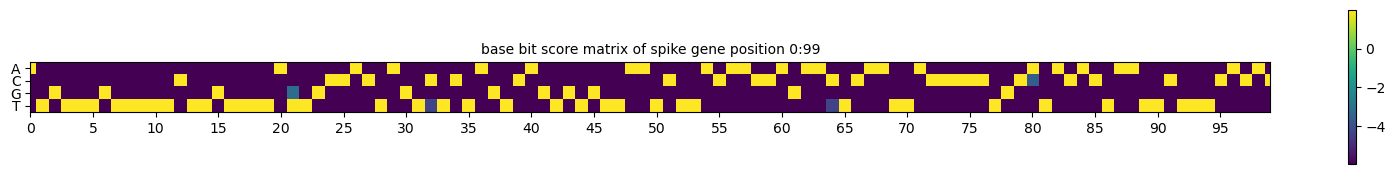

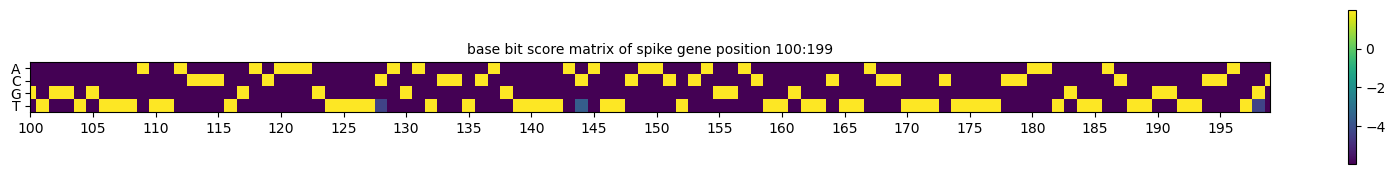

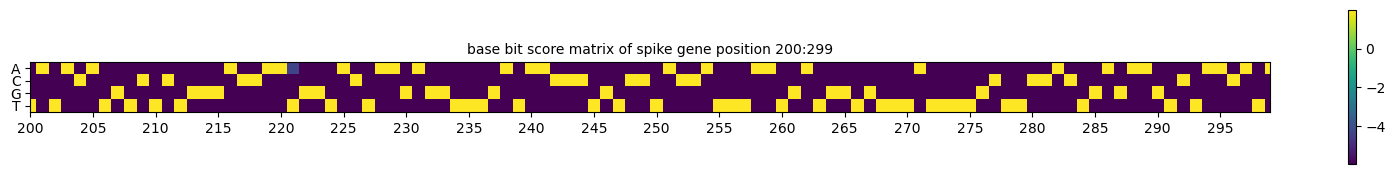

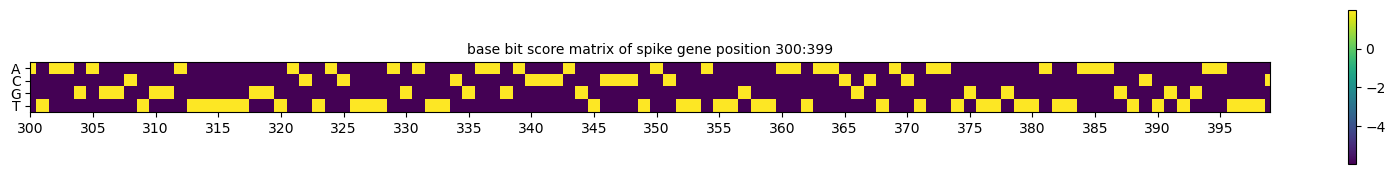

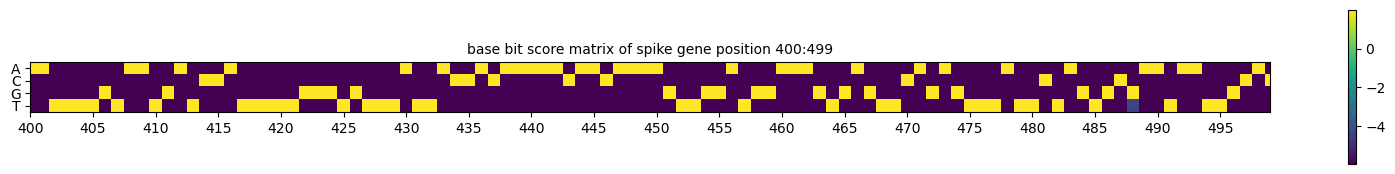

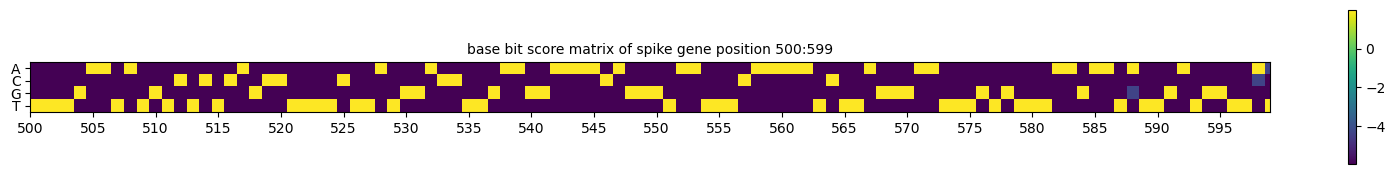

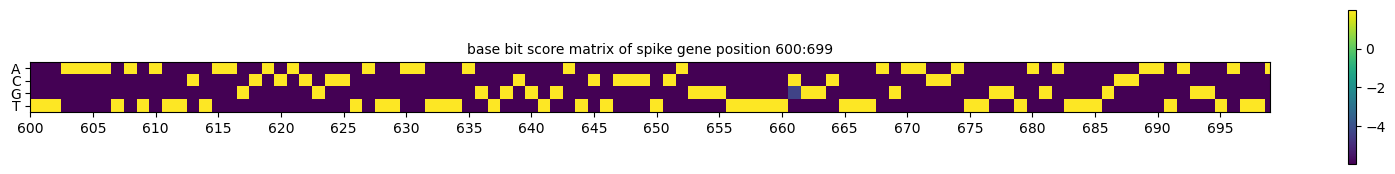

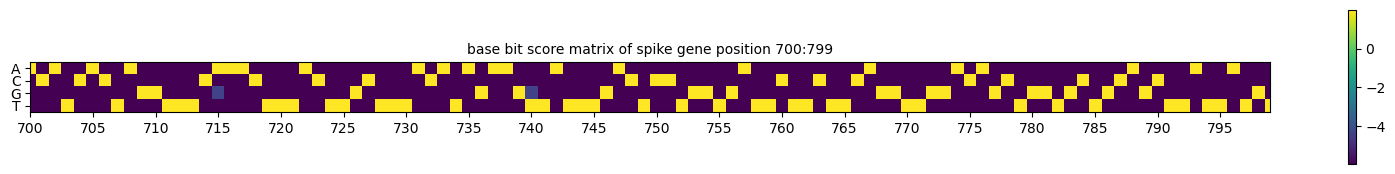

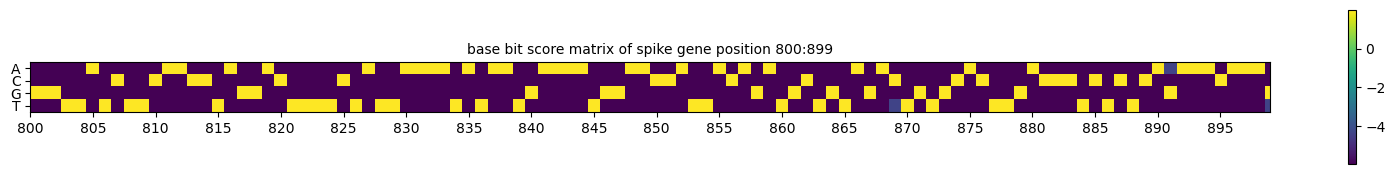

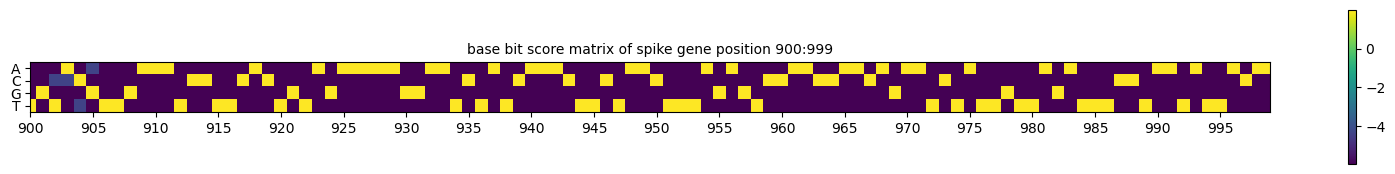

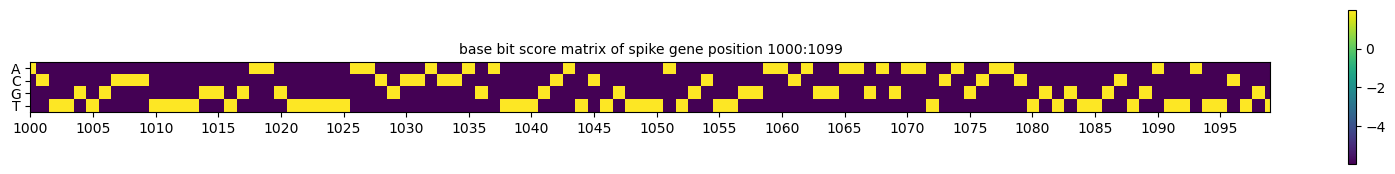

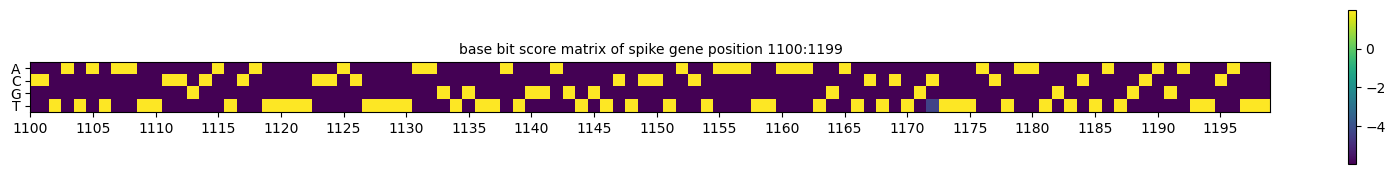

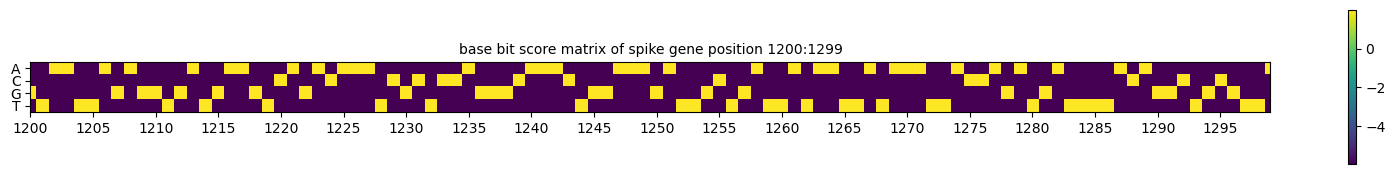

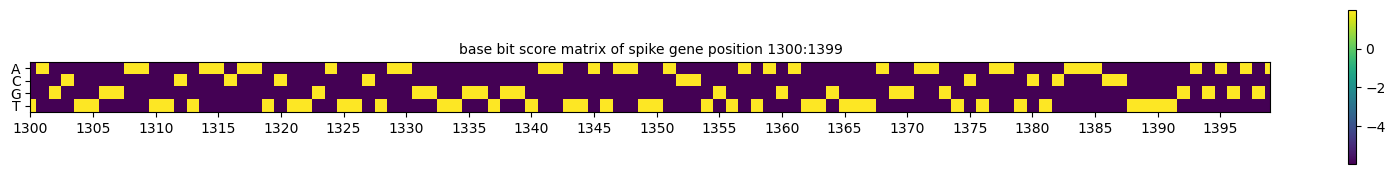

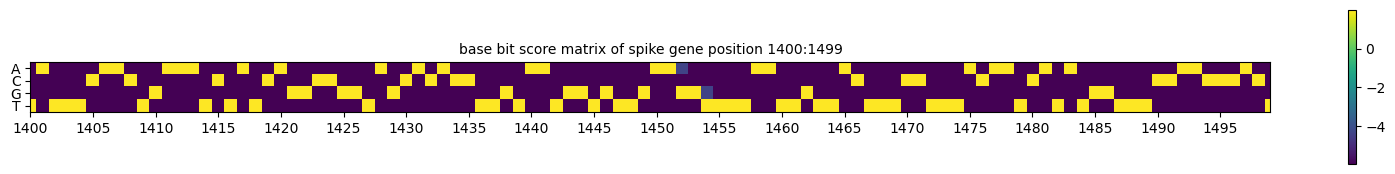

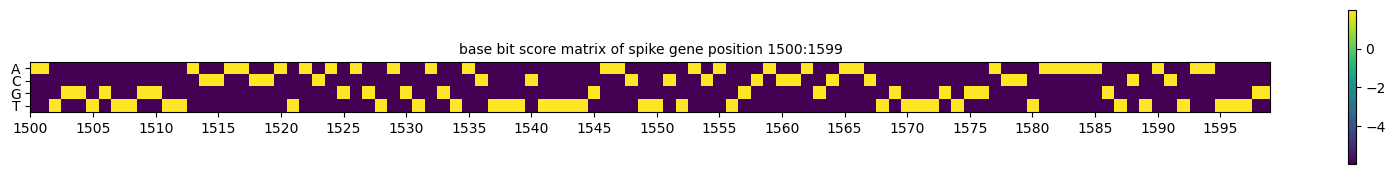

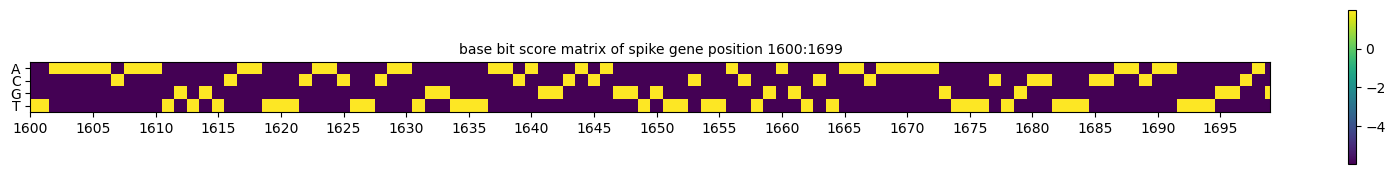

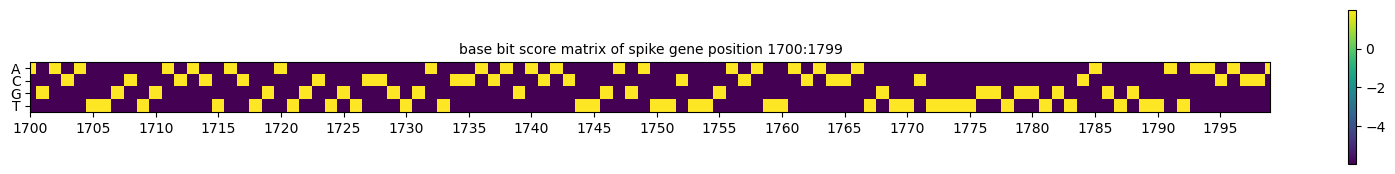

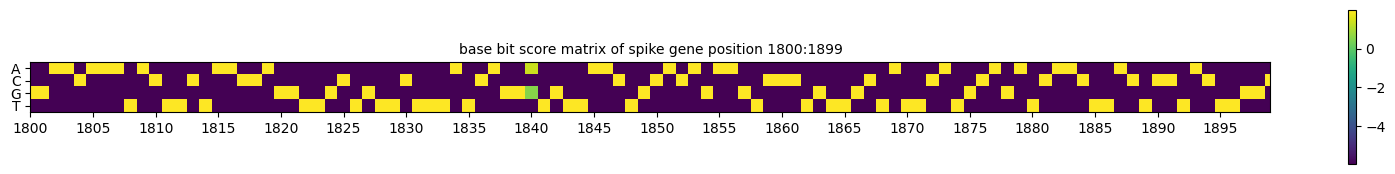

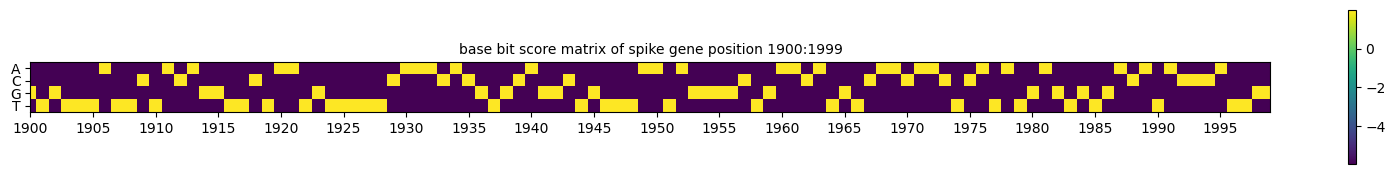

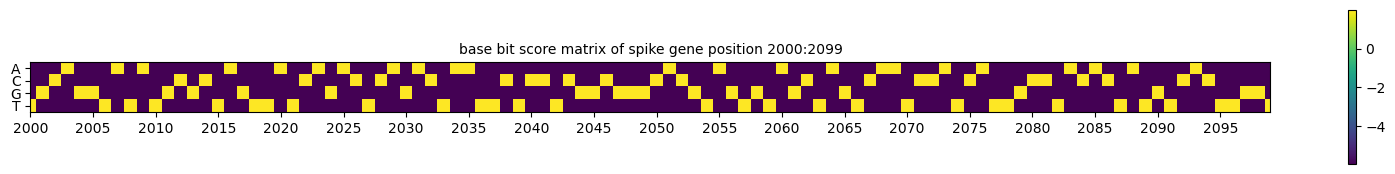

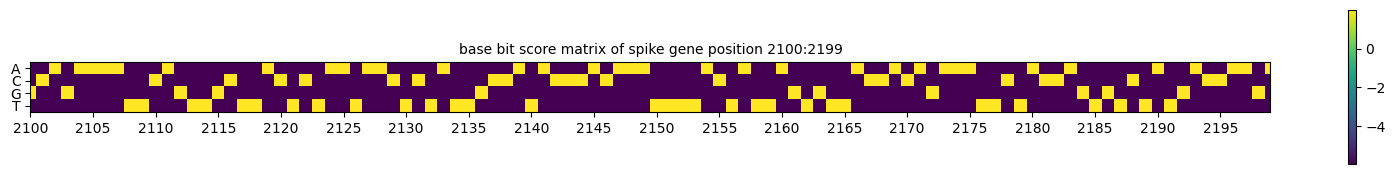

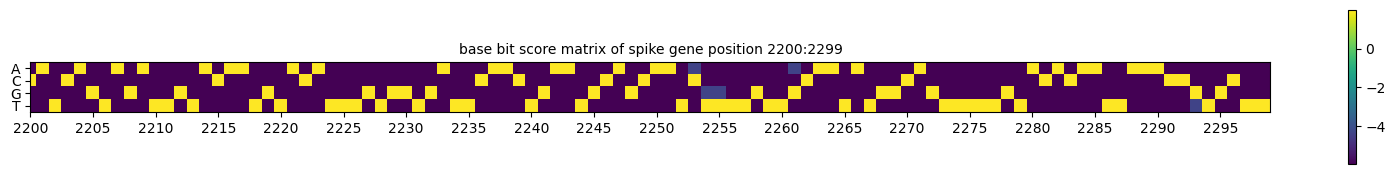

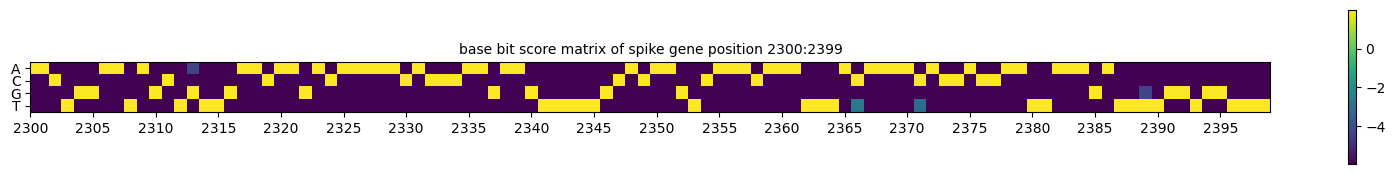

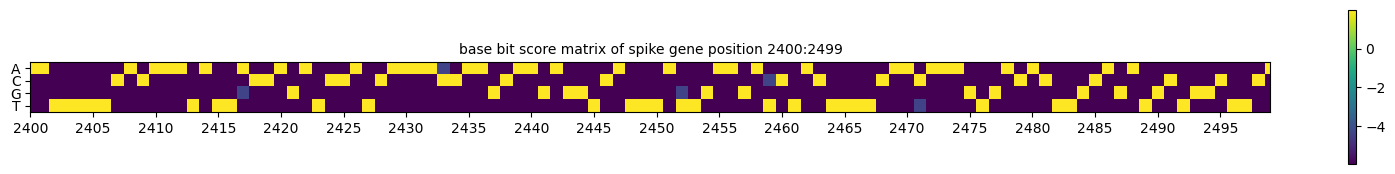

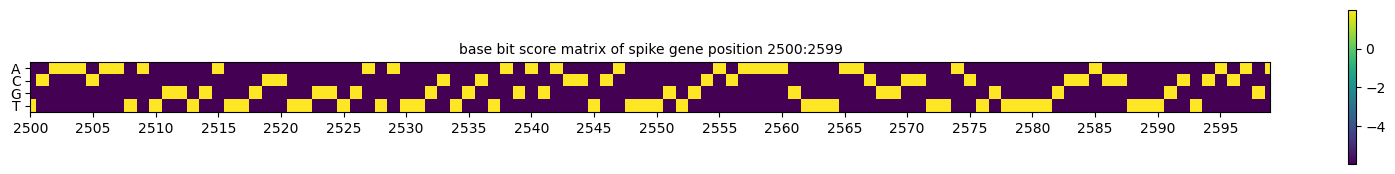

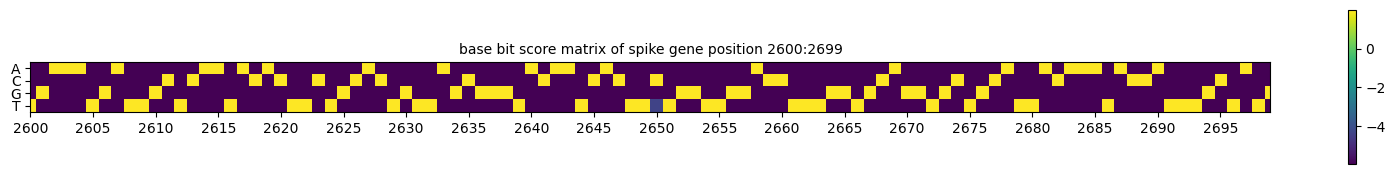

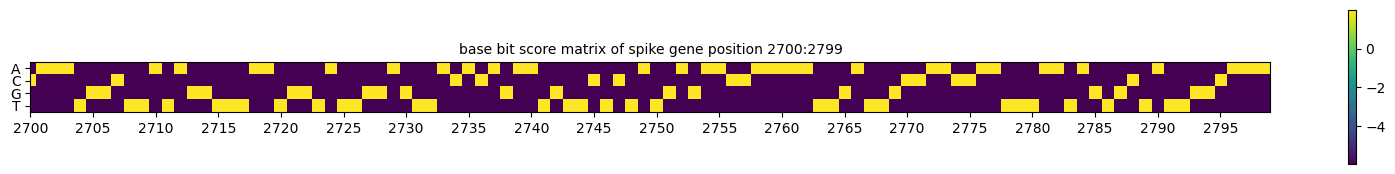

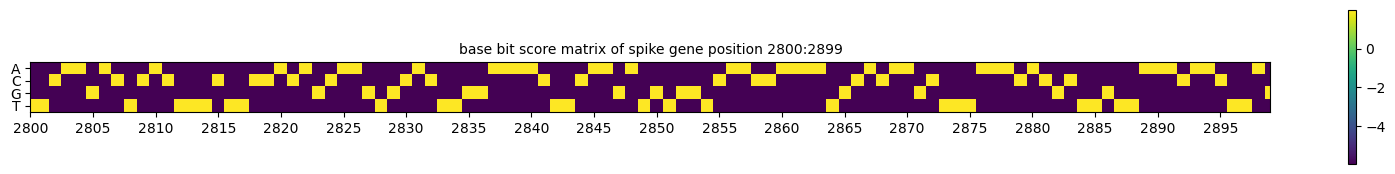

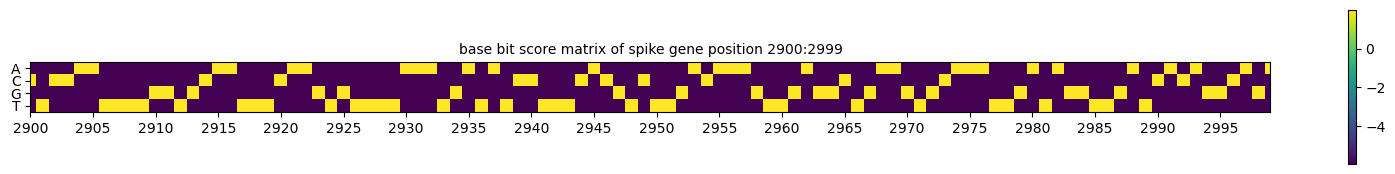

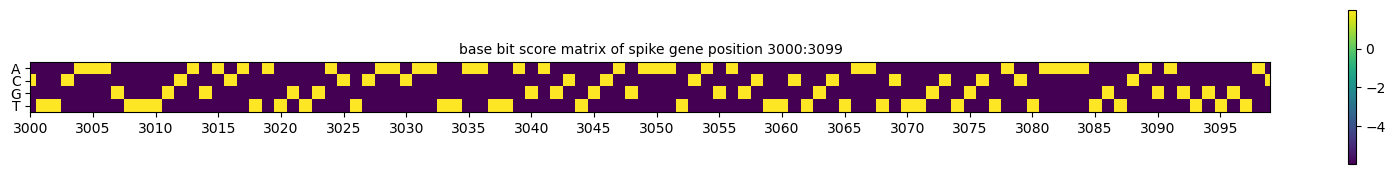

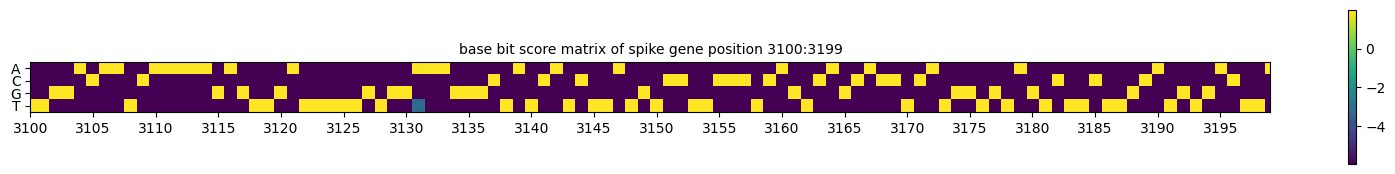

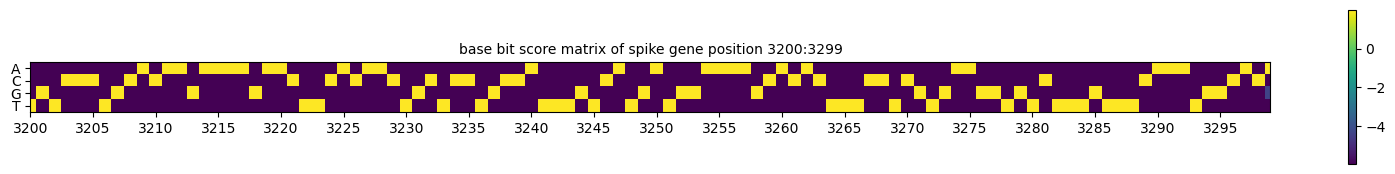

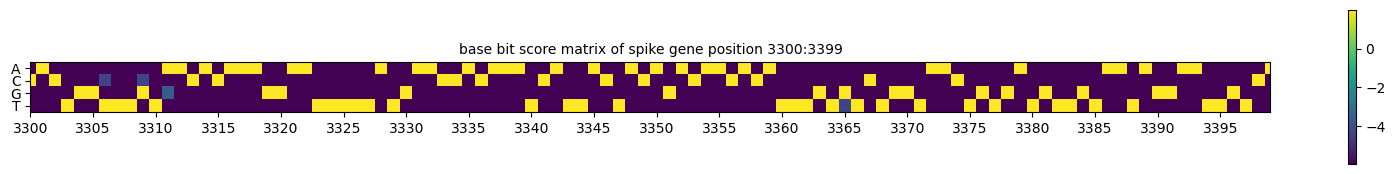

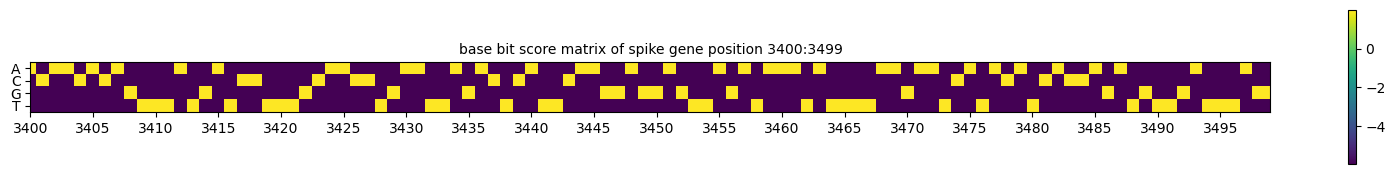

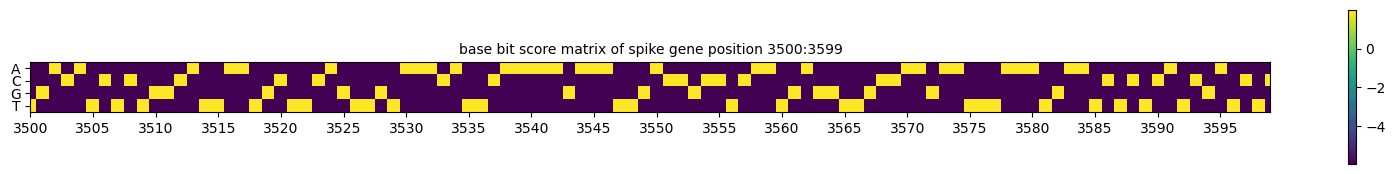

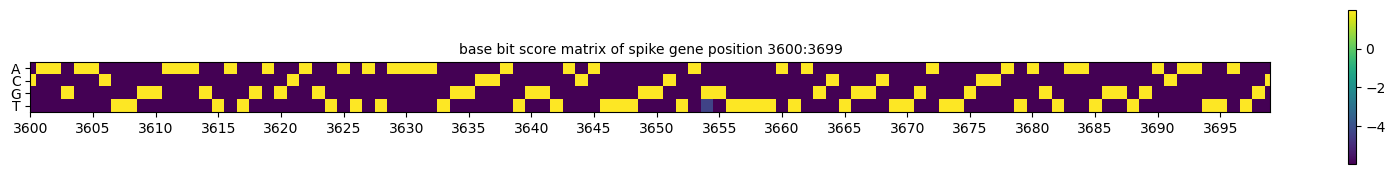

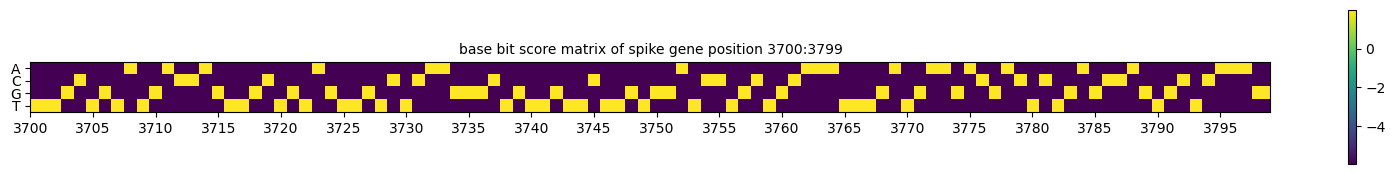

In [11]:
m = bit_matrix(gene_records, "spike gene")

## Konsensus sequence dari spike gene

In [12]:
print(m.degenerate_consensus)

ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAA